In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
class SVRGClassifier:
    def __init__(self, loss="log", lr=0.001, max_outer=10000, m_inner=1000, tol=1e-10, verbose=0, lam=1e-3):
        self.loss = loss
        self.lr = lr
        self.max_outer = max_outer
        self.m_inner = m_inner
        self.tol = tol
        self.verbose = verbose
        self.w = None
        self.bias = 0
        self.losses_ = []
        self.lam = lam

    def _compute_loss(self, X, y):
        pred = X @ self.w + self.bias
        if self.loss == "log":
            z = y * pred
            return np.mean(np.log(1 + np.exp(-z))) + 0.5 * self.lam * np.sum(self.w**2)
        else:
            return np.mean((y - pred) ** 2) + 0.5 * self.lam * np.sum(self.w**2)

    def _grad_sample_params(self, xi, yi, w, b):
        pred = xi @ w + b
        z = yi * pred
    
        if self.loss == "log":
            coeff = -yi / (1 + np.exp(z))          
            grad_w = coeff * xi + self.lam * w     
            grad_b = coeff                         
        else:
            coeff = pred - yi
            grad_w = coeff * xi + self.lam * w
            grad_b = coeff
    
        return grad_w, grad_b


    def _full_grad(self, X, y):
        pred = X @ self.w + self.bias
        z = y * pred
    
        if self.loss == "log":
            coeff = -y / (1 + np.exp(z))
        else:
            coeff = pred - y
    
        grad_w = X.T @ coeff / len(X) + self.lam * self.w
        grad_b = np.mean(coeff)
        return grad_w, grad_b


    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Convert labels once
        if self.loss == "log":
            y = 2*y - 1   # convert to ±1

        # Initialize
        self.w = np.random.randn(n_features) * 0.01
        self.bias = 0

        for outer in range(self.max_outer):
            w_tilde = self.w.copy()
            b_tilde = self.bias

            # vectorized full gradient
            grad_full_w, grad_full_b = self._full_grad(X, y)

            w = w_tilde.copy()
            b = b_tilde

            # inner loop
            for _ in range(self.m_inner):
                i = np.random.randint(0, n_samples)

                gw, gb = self._grad_sample_params(X[i], y[i], w, b)
                gw_t, gb_t = self._grad_sample_params(X[i], y[i], w_tilde, b_tilde)
                
                w -= self.lr * (gw - gw_t + grad_full_w)
                b -= self.lr * (gb - gb_t + grad_full_b)

            self.w, self.bias = w, b

            # monitor loss
            loss = self._compute_loss(X, y)
            self.losses_.append(loss)

            if self.verbose:
                print(f"outer={outer+1}, loss={loss:.6f}")

            if outer > 0 and abs(self.losses_[-2] - self.losses_[-1]) < self.tol:
                break

        return self

    def predict_proba(self, X):
        pred = X @ self.w + self.bias
    
        if self.loss == "log":
            p = 1 / (1 + np.exp(-pred))
            return np.stack([1-p, p], axis=1)
    
        p = 1 / (1 + np.exp(-pred))
        return np.stack([1-p, p], axis=1)


    def predict(self, X):
        if self.loss == "squared":
            return (X @ self.w + self.bias >= 0.5).astype(int)
        else:
            sign_pred = np.where(X @ self.w + self.bias >= 0, 1, -1)
            return ((sign_pred + 1) // 2).astype(int)


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

In [4]:
# Fetch dataset
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = (bank_marketing.data.targets == "yes").astype(int)  # convert yes/no -> 1/0

# One-hot encode categorical features
X = pd.get_dummies(X)

# Scale numeric features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y.values.ravel(), test_size=0.2, random_state=42
)


In [5]:
classifier = SVRGClassifier(loss="squared", lr= 1e-3, lam=2 * 1e-4, verbose=0)
classifier.fit(X_train, y_train)

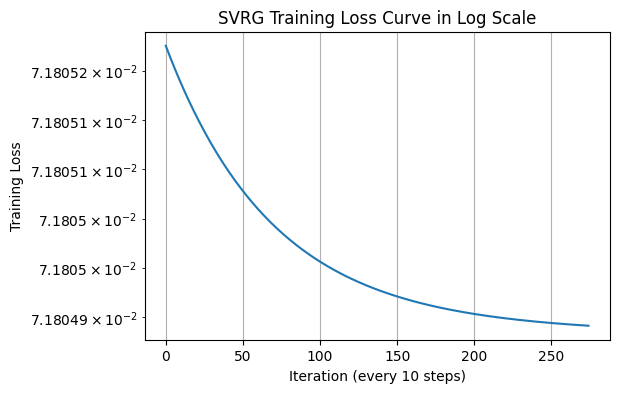

In [6]:
plt.figure(figsize=(6,4))
plt.plot(classifier.losses_[200:])
plt.xlabel("Iteration (every 10 steps)")
plt.ylabel("Training Loss")
plt.title("SVRG Training Loss Curve in Log Scale")
plt.yscale('log')
plt.grid(True)
plt.show()

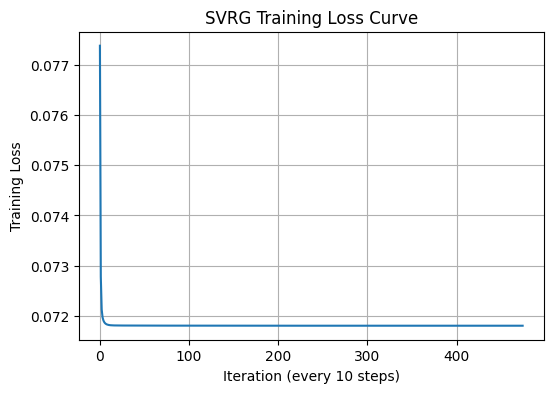

In [7]:
plt.figure(figsize=(6,4))
plt.plot(classifier.losses_)
plt.xlabel("Iteration (every 10 steps)")
plt.ylabel("Training Loss")
plt.title("SVRG Training Loss Curve")
#plt.yscale('log')
plt.grid(True)
plt.show()

In [8]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8970474400088466


In [9]:
test_loss = classifier._compute_loss(X_test, y_test)
print("Test Loss:", test_loss)

Test Loss: 0.07324760459248733


In [10]:
len(classifier.losses_)

475

In [11]:
train_loss = classifier._compute_loss(X_train, y_train)
print("Test Loss:", train_loss)

Test Loss: 0.0718048913608262


In [12]:
classifier.w

array([ 0.00288858,  0.00285208,  0.00798151,  0.12079937, -0.00414894,
       -0.00659506,  0.00186171,  0.00964277,  0.00509359,  0.00168052,
        0.00016786,  0.0084567 ,  0.01175822,  0.00262501,  0.0053257 ,
        0.01334475,  0.00683516,  0.0044201 ,  0.00080699, -0.00445113,
        0.00543207, -0.00233716,  0.00066763,  0.00744776,  0.01051256,
        0.01010796,  0.01137029, -0.01318843,  0.00124711, -0.00708971,
        0.04165636,  0.01918295,  0.00883205, -0.01310001,  0.01118223,
        0.00186646, -0.01397262, -0.01478641,  0.01445541,  0.03110975,
       -0.0011435 , -0.01239515,  0.02373201,  0.02287456,  0.00613826,
        0.00905879,  0.07688414])

In [13]:
classifier.losses_

[np.float64(0.07738051752667467),
 np.float64(0.07278093649479134),
 np.float64(0.0721262764656784),
 np.float64(0.07196785410904732),
 np.float64(0.07190601086201891),
 np.float64(0.07187165445446933),
 np.float64(0.07185106650325242),
 np.float64(0.0718380506296015),
 np.float64(0.07182920052610027),
 np.float64(0.0718231965533011),
 np.float64(0.07181911323501919),
 np.float64(0.0718162816877814),
 np.float64(0.07181435228381293),
 np.float64(0.07181297374507813),
 np.float64(0.07181199045132504),
 np.float64(0.07181126878315335),
 np.float64(0.07181073401181864),
 np.float64(0.07181032906714994),
 np.float64(0.07181001212630196),
 np.float64(0.07180975634588185),
 np.float64(0.07180954845005333),
 np.float64(0.07180937236119299),
 np.float64(0.07180922290874574),
 np.float64(0.0718090920783445),
 np.float64(0.0718089759080912),
 np.float64(0.07180887213382507),
 np.float64(0.07180877836806336),
 np.float64(0.07180869155471227),
 np.float64(0.07180861049746674),
 np.float64(0.071808